Imports

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pickle

from keras.models import Sequential
from keras.layers import Dense

import mysql.connector
from dotenv import load_dotenv
from os import getenv
from sqlalchemy import create_engine

from imblearn.over_sampling import SMOTE
# These are all the model tried, I will leave it to show the how extensive was the process


Data Cleaning

In [9]:
df = pd.read_csv(r'Final\Productivity\vizualization\rawdata_productivity.csv')
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,3/11/2015,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,3/11/2015,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,3/11/2015,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,3/11/2015,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [10]:
display(df.isna().sum(),
       df.duplicated().sum(),
       df.dtypes 
)

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

0

date                      object
quarter                   object
department                object
day                       object
team                       int64
targeted_productivity    float64
smv                      float64
wip                      float64
over_time                  int64
incentive                  int64
idle_time                float64
idle_men                   int64
no_of_style_change         int64
no_of_workers            float64
actual_productivity      float64
dtype: object

In [11]:
df['wip'].fillna(0, inplace=True)    # I will consider Working in Progress as a metric of incompletion so when it is null means there is nothing left to complete.
df['date'] = pd.to_datetime(df['date'])
df.rename(columns={'day': 'week_day'}, inplace=True)
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['department'] = df['department'].replace({'finishing ': 'finishing'})

df

,date,quarter,department,week_day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,day,month
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,1
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,1,1
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,Quarter2,finishing,Wednesday,10,0.75,2.90,0.0,960,0,0.0,0,0,8.0,0.628333,11,3
1193,2015-03-11,Quarter2,finishing,Wednesday,8,0.70,3.90,0.0,960,0,0.0,0,0,8.0,0.625625,11,3
1194,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,0.0,960,0,0.0,0,0,8.0,0.625625,11,3
1195,2015-03-11,Quarter2,finishing,Wednesday,9,0.75,2.90,0.0,1800,0,0.0,0,0,15.0,0.505889,11,3


In [12]:
df.nunique()

date                      59
quarter                    5
department                 2
week_day                   6
team                      12
targeted_productivity      9
smv                       70
wip                      549
over_time                143
incentive                 48
idle_time                 12
idle_men                  10
no_of_style_change         3
no_of_workers             61
actual_productivity      879
day                       30
month                      3
dtype: int64

In [13]:
df['idle_time'].unique()

array([  0. ,  90. , 150. , 270. , 300. ,   2. ,   5. ,   8. ,   4.5,
         3.5,   4. ,   6.5])

In [14]:
print(df.quarter.value_counts())
df[df['quarter']=='Quarter5']

Quarter1    360
Quarter2    335
Quarter4    248
Quarter3    210
Quarter5     44
Name: quarter, dtype: int64


,date,quarter,department,week_day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,day,month
498,2015-01-29,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230,29,1
499,2015-01-29,Quarter5,finishing,Thursday,4,0.80,4.30,0.0,1200,0,0.0,0,0,10.0,0.989000,29,1
500,2015-01-29,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186,29,1
501,2015-01-29,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800,29,1
502,2015-01-29,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130,29,1
503,2015-01-29,Quarter5,finishing,Thursday,6,0.50,2.90,0.0,1200,0,0.0,0,0,10.0,0.899000,29,1
504,2015-01-29,Quarter5,finishing,Thursday,8,0.65,4.15,0.0,960,0,0.0,0,0,8.0,0.877552,29,1
505,2015-01-29,Quarter5,finishing,Thursday,11,0.60,2.90,0.0,960,0,0.0,0,0,8.0,0.864583,29,1
506,2015-01-29,Quarter5,finishing,Thursday,10,0.80,3.94,0.0,1200,0,0.0,0,0,10.0,0.856950,29,1
507,2015-01-29,Quarter5,finishing,Thursday,1,0.75,3.94,0.0,1200,0,0.0,0,0,10.0,0.853667,29,1


In [15]:
df['quarter'] = df['quarter'].replace({'Quarter5': '4', 'Quarter4': '4', 'Quarter3': '3', 'Quarter2': '2', 'Quarter1': '1'})
num = df.select_dtypes('number').drop(columns=['day', 'month', 'team'])
cat = df.select_dtypes('object').merge(df[['day', 'team']], on= df['month'], how='inner').rename(columns={'key_0': 'month'})
dfd = pd.get_dummies(df)

dfd

,date,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,...,quarter_3,quarter_4,department_finishing,department_sweing,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday
0,2015-01-01,8,0.80,26.16,1108.0,7080,98,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,2015-01-01,1,0.75,3.94,0.0,960,0,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2015-01-01,11,0.80,11.41,968.0,3660,50,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,2015-01-01,12,0.80,11.41,968.0,3660,50,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,2015-01-01,6,0.80,25.90,1170.0,1920,50,0.0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,2015-03-11,10,0.75,2.90,0.0,960,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1193,2015-03-11,8,0.70,3.90,0.0,960,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1194,2015-03-11,7,0.65,3.90,0.0,960,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
1195,2015-03-11,9,0.75,2.90,0.0,1800,0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1


To SQL

In [16]:
calendar = df[['date', 'week_day']].drop_duplicates(keep='last').reset_index().rename(columns={'index': 'calendar_id'})
week = pd.DataFrame(df['week_day'].value_counts(normalize=True).reset_index(), index= [1,4,2,0,3,5]).reset_index().rename(columns={'index': 'week_day', 'week_day': 'proportion', 'level_0': 'week_id'})
hr = df[['date', 'quarter', 'department', 'team', 'no_of_workers']]
productivity = df[['targeted_productivity', 'actual_productivity']]
production = df[['week_day', 'smv', 'wip', 'no_of_style_change']]
finance = df[['date', 'incentive', 'over_time', 'idle_time', 'idle_men']]

In [17]:
calendar = calendar.merge(week, on= 'week_day').drop(columns=['week_day', 'proportion']) # Connection with the week
finance = calendar.merge(finance, on= 'date').drop(columns=['date', 'week_id']) # Required for functioning of payments
hr = calendar.merge(hr, on= 'date').drop(columns=['date', 'week_id']) # Quater assimilation
production = production.merge(week, on= 'week_day').drop(columns=['week_day', 'proportion']) # Required for metric in production
finance

,calendar_id,incentive,over_time,idle_time,idle_men
0,18,98,7080,0.0,0
1,18,0,960,0.0,0
2,18,50,3660,0.0,0
3,18,50,3660,0.0,0
4,18,50,1920,0.0,0
...,...,...,...,...,...
1192,1196,0,960,0.0,0
1193,1196,0,960,0.0,0
1194,1196,0,960,0.0,0
1195,1196,0,1800,0.0,0


In [ ]:
load_dotenv()

In [18]:
# get connected to the sql 
pw = getenv('pw')
host = getenv('host')
user= 'root'

conn = mysql.connector.connect(host= host, user= user, password= pw)

In [19]:
#now are creating a cursor, that will hold our query, execute it, and fetch results

cursor = conn.cursor()

In [20]:
# querying the database to sql

query = """CREATE DATABASE IF NOT EXISTS factory;"""

cursor.execute(query)

query1 = "SHOW DATABASES"
cursor.execute(query1)
cursor.fetchall()

In [21]:
# sending to sql
eng = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/factory')
hr.to_sql('human_resources', con= eng)

In [22]:
# sending to sql
eng2 = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/factory')
productivity.to_sql('productivity', con= eng2)

In [23]:
# sending to sql
eng3 = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/factory')
production.to_sql('production', con= eng3)

In [24]:
# sending to sql
eng4 = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/factory')
finance.to_sql('finance', con= eng4)

In [25]:
# sending to sql
eng5 = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/factory')
calendar.to_sql('calendar', con= eng5)

In [26]:
# sending to sql
eng6 = create_engine(f'mysql+pymysql://{user}:{pw}@{host}/factory')
week.to_sql('week_proportion', con= eng6)

Feature Engeneering

C:\Users\User\AppData\Local\Temp\ipykernel_14180\527465524.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=np.abs(dfd.corr(method='spearman'))


<Axes: >

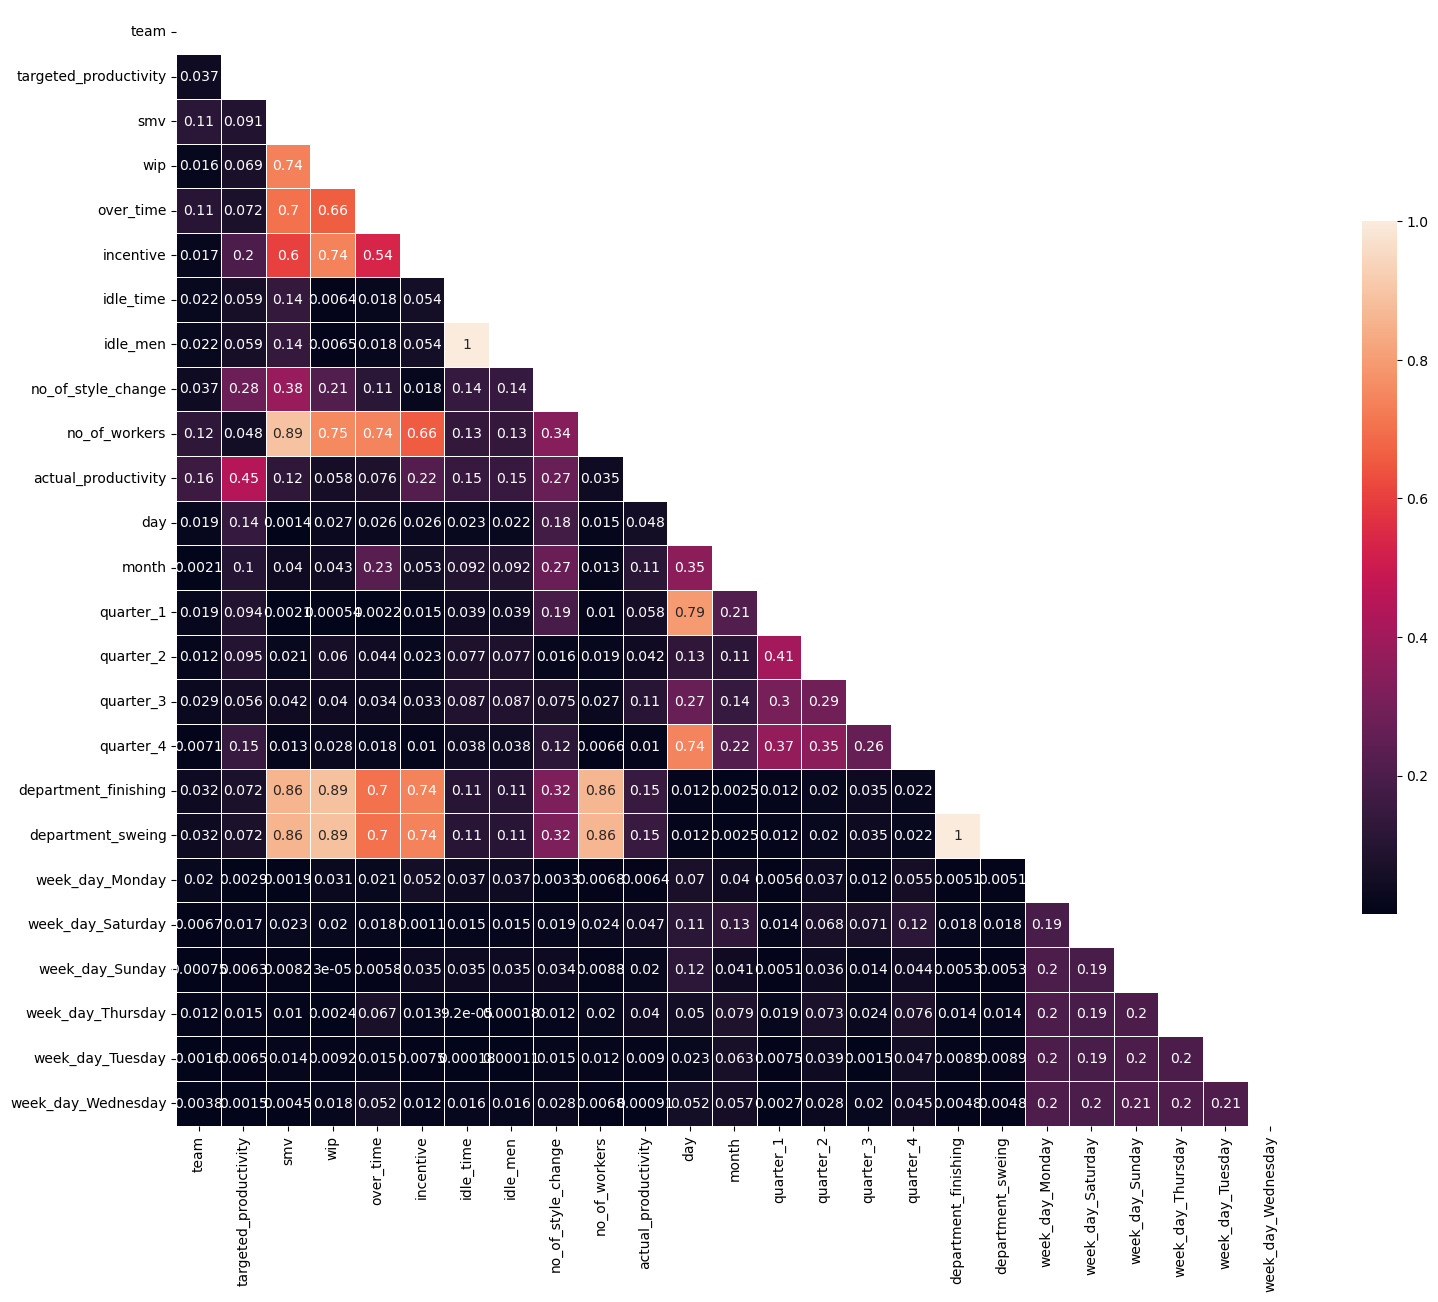

In [27]:
corr=np.abs(dfd.corr(method='spearman'))

# Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

In [28]:
corr = dfd.corrwith(df["actual_productivity"], method='spearman')
columns = list(corr[abs(corr)<0.20].index)

C:\Users\User\AppData\Local\Temp\ipykernel_14180\3128962495.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dfd.corrwith(df["actual_productivity"], method='spearman')


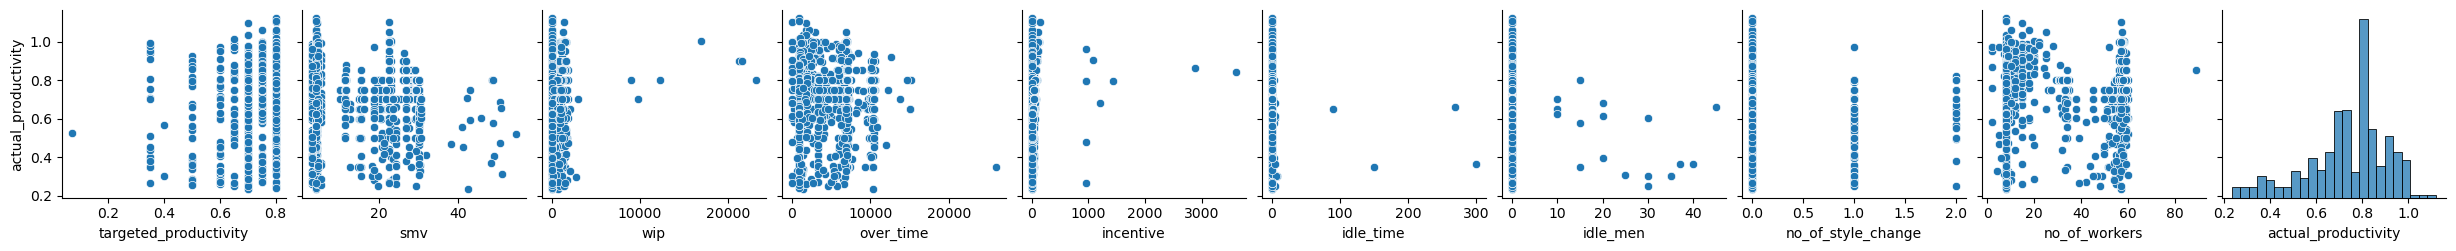

In [29]:
sns.pairplot(num, y_vars= "actual_productivity")

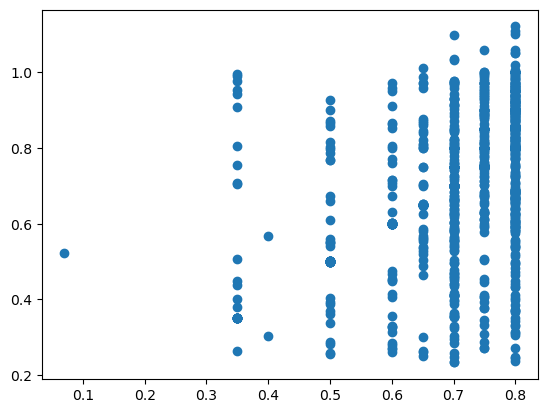

In [30]:
plt.scatter(x=df['targeted_productivity'], y =df['actual_productivity'])

Targeting

In [31]:
feature = dfd.drop(columns=['actual_productivity', 'date'])
target = dfd['actual_productivity']

display(feature,
        target
        )

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,quarter_3,quarter_4,department_finishing,department_sweing,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday
0,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,0,0,1,0,0,0,1,0,0
1,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,...,0,0,1,0,0,0,0,1,0,0
2,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,1,0,0
3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,1,0,0
4,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,10,0.75,2.90,0.0,960,0,0.0,0,0,8.0,...,0,0,1,0,0,0,0,0,0,1
1193,8,0.70,3.90,0.0,960,0,0.0,0,0,8.0,...,0,0,1,0,0,0,0,0,0,1
1194,7,0.65,3.90,0.0,960,0,0.0,0,0,8.0,...,0,0,1,0,0,0,0,0,0,1
1195,9,0.75,2.90,0.0,1800,0,0.0,0,0,15.0,...,0,0,1,0,0,0,0,0,0,1


0       0.940725
1       0.886500
2       0.800570
3       0.800570
4       0.800382
          ...   
1192    0.628333
1193    0.625625
1194    0.625625
1195    0.505889
1196    0.394722
Name: actual_productivity, Length: 1197, dtype: float64

In [32]:
xTrain, xTest, yTrain, yTest = train_test_split(feature, target, test_size=0.15)
yTrain

27     0.800319
30     0.800125
601    0.999995
543    1.000671
210    0.650041
         ...   
671    0.568260
834    0.700603
574    0.561979
645    0.799963
197    0.858144
Name: actual_productivity, Length: 1017, dtype: float64

In [33]:
norm = StandardScaler()
norm.fit(xTrain)
xTrainN = norm.transform(xTrain)
xTestN = norm.transform(xTest)
xTestN

array([[ 0.16227536, -0.30710627,  0.76658938, ..., -0.44325003,
        -0.4495861 , -0.4606054 ],
       [ 0.16227536,  0.71457211,  0.98319524, ..., -0.44325003,
        -0.4495861 , -0.4606054 ],
       [ 0.74338112, -0.30710627, -1.12779408, ..., -0.44325003,
        -0.4495861 ,  2.17105577],
       ...,
       [ 1.61503976,  0.71457211, -1.01949115, ..., -0.44325003,
        -0.4495861 , -0.4606054 ],
       [-0.41883041, -0.81794547,  1.12821102, ..., -0.44325003,
        -0.4495861 , -0.4606054 ],
       [-0.41883041, -0.30710627,  1.12821102, ..., -0.44325003,
        -0.4495861 ,  2.17105577]])

In [34]:
grid = {
    'n_estimators': [10, 50, 100],                   # Number of base estimators
    'max_samples': [0.5, 0.75, 1.0],                 # Fraction of samples to draw
    'max_features': [0.5, 0.75, 1.0],                # Fraction of features to draw
    'bootstrap': [False],                      # Whether samples are drawn with replacement
    'estimator__max_depth': [10, 20, 30], # Maximum depth of the decision tree
    'estimator__min_samples_split': [2, 5, 10], # Minimum number of samples to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4]    # Minimum number of samples to be at a leaf node
}

In [35]:
model1 = GradientBoostingRegressor(learning_rate= 0.01,
 max_depth= 5,
 min_samples_leaf= 2,
 min_samples_split= 5,
 n_estimators= 600,
 subsample= 0.8)
# Best Hyperparameter yet

In [36]:
search = GridSearchCV(estimator = model1, param_grid = grid, cv=5, return_train_score=True)

In [37]:
model1.fit(xTrainN, yTrain)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=600, subsample=0.8)

In [38]:
# best_model = search.best_estimator_
# search.best_params_

In [39]:
pred = model1.predict(xTestN)
pred1 = model1.predict(xTrainN)

print("RMSE:", mean_squared_error(pred, yTest, squared=False))
print("RMSE train:", mean_squared_error(pred1, yTrain, squared=False))
print("R2 score:", model1.score(xTestN, yTest))
print("R2 score on Train:", model1.score(xTrainN, yTrain))
print("Difference:", model1.score(xTrainN, yTrain)-model1.score(xTestN, yTest))

RMSE: 0.12764580264255432
RMSE train: 0.07183187508007685
R2 score: 0.524916182426068
R2 score on Train: 0.8264714241049534
Difference: 0.3015552416788855


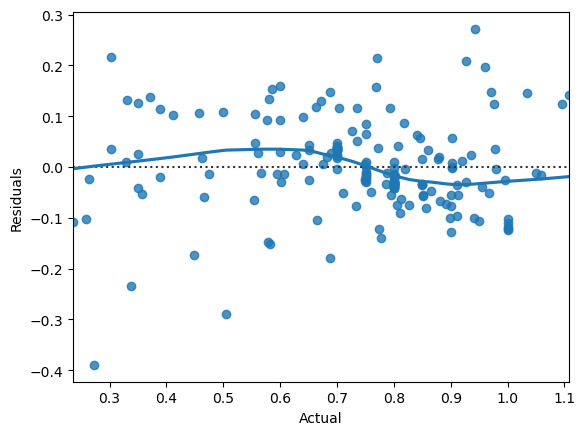

In [40]:
residuals = yTest - pred
sns.residplot(x=yTest, y=residuals, lowess=True)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.show()

Classification

In [41]:
labels = ['Low', 'Mid', 'High', 'Very H.']
qTarget = pd.qcut(df['actual_productivity'], q=4, labels=labels, retbins=True)
qTarget                             # Will not be used because it underperform

(0       Very H.
 1       Very H.
 2          High
 3          High
 4          High
          ...   
 1192        Low
 1193        Low
 1194        Low
 1195        Low
 1196        Low
 Name: actual_productivity, Length: 1197, dtype: category
 Categories (4, object): ['Low' < 'Mid' < 'High' < 'Very H.'],
 array([0.23370548, 0.65030714, 0.77333333, 0.85025253, 1.1204375 ]))

In [42]:
bins = [df['actual_productivity'].min(), 0.45, 0.65, 0.85, df['actual_productivity'].max()]
claTarget = pd.cut(df['actual_productivity'], bins=bins, labels=labels, include_lowest=True)
claTarget

0       Very H.
1       Very H.
2          High
3          High
4          High
         ...   
1192        Mid
1193        Mid
1194        Mid
1195        Mid
1196        Low
Name: actual_productivity, Length: 1197, dtype: category
Categories (4, object): ['Low' < 'Mid' < 'High' < 'Very H.']

In [43]:
# Important to flag certain vices and pattern to the model
copy = df.copy()
copy['target'] = claTarget

In [44]:
def helper(df, obj):        # So here I am going to highlight some of them
    thedict={}
    for i in df.columns:
        t = df[df['target']==str(obj)][i].value_counts(normalize=True)
        if t.max()>=0.65:
            thedict[i]= [t.idxmax(), t.max()]
        else:
            continue
    return thedict

In [45]:
copy[(copy['incentive']==0)&( copy['idle_time']==0.0)&(copy['idle_men']==0)&(copy['no_of_style_change']==0)]['target'].value_counts(normalize=True)

Very H.    0.362477
High       0.329690
Mid        0.182149
Low        0.125683
Name: target, dtype: float64

In [46]:
copy[(copy['quarter']=='4')]['target'].value_counts(normalize=True)

High       0.431507
Very H.    0.291096
Mid        0.150685
Low        0.126712
Name: target, dtype: float64

In [47]:
copy[copy['no_of_style_change']==2].groupby('target').agg({'target':['count'], 'no_of_workers': ['mean']}).iloc[2:3,:1]
# Comfirming some of them

,target
,count
target,
High,22


In [48]:
high70 = helper(copy, "High")
low70 = helper(copy, "Low")
display(low70,high70)

{'incentive': [0, 0.8333333333333334],
 'idle_time': [0.0, 0.9166666666666666],
 'idle_men': [0, 0.9166666666666666],
 'no_of_style_change': [0, 0.7962962962962963],
 'target': ['Low', 1.0]}

{'department': ['sweing', 0.7181663837011885],
 'idle_time': [0.0, 0.9915110356536503],
 'idle_men': [0, 0.9915110356536503],
 'no_of_style_change': [0, 0.8590831918505942],
 'target': ['High', 1.0]}

In [49]:
def direction(row):
    row['itsVH'] = row['incentive']>= 70
    row['itsH'] = row['department_sweing'] == 1
    row['itsL'] = row['incentive'] == 0
    row['itsH'] = row['incentive'] == 50
    
    return row

In [50]:
feature1 = feature.apply(direction, axis=1)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(feature1, claTarget, test_size=0.15)

In [52]:
norm = StandardScaler()
norm.fit(x_train)
x_trainN = norm.transform(x_train)
x_testN = norm.transform(x_test)

In [53]:
# Will standardze the whole df to pickle it for a good website prediction
# X = norm.fit_transform(feature1)
# norm.fit(feature1)


In [54]:
# pickle.dump(norm, open('scaler.p','wb'))

In [55]:
gridC = {
    'base_estimator__C': [205],  # Regularization strength
    'n_estimators': [10],                 # Number of base estimators in the ensemble
    'max_samples': [0.5],               # Max samples used for each base estimator
    'max_features': [1.0],              # Max features used for each base estimator
    'base_estimator__max_iter': [110]                    # Whether samples are drawn with replacement
}

In [56]:
modelC = BaggingClassifier(LogisticRegression())   

In [57]:
searchC = GridSearchCV(estimator = modelC, param_grid = gridC, cv=10, return_train_score=True) # Best Hyperparameter on the grid

In [58]:
# Since qcut performs poorly and does not reflect correctly the target
claTarget.value_counts(normalize=True)        # I smote sample the data.

High       0.492063
Very H.    0.267335
Mid        0.150376
Low        0.090226
Name: actual_productivity, dtype: float64

In [59]:
sm = SMOTE()
x_trainsm,y_trainsm = sm.fit_resample(x_trainN, y_train)

In [60]:
# Solve the imbalance issue for better training
# x, y = sm.fit_resample(X, claTarget)

In [61]:
# Final Training
# searchC.fit(x, y)

In [62]:
searchC.fit(x_trainsm, y_trainsm)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:674: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  estimator = estimator.set_params(**cloned_parameters)
c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increas

GridSearchCV(cv=10, estimator=BaggingClassifier(estimator=LogisticRegression()),
             param_grid={'base_estimator__C': [205],
                         'base_estimator__max_iter': [110],
                         'max_features': [1.0], 'max_samples': [0.5],
                         'n_estimators': [10]},
             return_train_score=True)

In [63]:
best_modelC = searchC.best_estimator_
searchC.best_params_

{'base_estimator__C': 205,
 'base_estimator__max_iter': 110,
 'max_features': 1.0,
 'max_samples': 0.5,
 'n_estimators': 10}

In [64]:
predC = best_modelC.predict(x_testN)
pred1C = best_modelC.predict(x_trainsm)

print("R2 score:", best_modelC.score(x_testN, y_test))
print("R2 score on Train:", best_modelC.score(x_trainsm, y_trainsm))
print("Difference:", best_modelC.score(x_trainsm, y_trainsm)-best_modelC.score(x_testN, y_test))
print("Classification:", classification_report(y_pred = predC, y_true = y_test))
print("Classification train:", classification_report(y_pred = pred1C, y_true = y_trainsm))

R2 score: 0.5833333333333334
R2 score on Train: 0.656003937007874
Difference: 0.07267060367454059
Classification:               precision    recall  f1-score   support

        High       0.77      0.58      0.66        81
         Low       0.35      0.73      0.48        15
         Mid       0.46      0.39      0.42        41
     Very H.       0.58      0.72      0.65        43

    accuracy                           0.58       180
   macro avg       0.54      0.61      0.55       180
weighted avg       0.62      0.58      0.59       180

Classification train:               precision    recall  f1-score   support

        High       0.76      0.61      0.67       508
         Low       0.63      0.75      0.68       508
         Mid       0.64      0.55      0.59       508
     Very H.       0.63      0.71      0.67       508

    accuracy                           0.66      2032
   macro avg       0.66      0.66      0.65      2032
weighted avg       0.66      0.66      0.65      

In [65]:
# pickle.dump(best_modelC, open("productivity_classifier.p","wb")) 
# pickle this model that got the best results

Categorical Solution to a Regression Problem

In [66]:
findPerc = feature.merge(claTarget, left_index=True, right_index=True)
findPerc = pd.get_dummies(findPerc)
findPerc

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,...,week_day_Monday,week_day_Saturday,week_day_Sunday,week_day_Thursday,week_day_Tuesday,week_day_Wednesday,actual_productivity_Low,actual_productivity_Mid,actual_productivity_High,actual_productivity_Very H.
0,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,...,0,0,0,1,0,0,0,0,0,1
1,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,...,0,0,0,1,0,0,0,0,0,1
2,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,0,1,0
3,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,...,0,0,0,1,0,0,0,0,1,0
4,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,10,0.75,2.90,0.0,960,0,0.0,0,0,8.0,...,0,0,0,0,0,1,0,1,0,0
1193,8,0.70,3.90,0.0,960,0,0.0,0,0,8.0,...,0,0,0,0,0,1,0,1,0,0
1194,7,0.65,3.90,0.0,960,0,0.0,0,0,8.0,...,0,0,0,0,0,1,0,1,0,0
1195,9,0.75,2.90,0.0,1800,0,0.0,0,0,15.0,...,0,0,0,0,0,1,0,1,0,0


In [67]:
xTrain1, xTest1, yTrain1, yTest1 = train_test_split(findPerc, target, test_size=0.15)

In [68]:
norm = StandardScaler()
norm.fit(xTrain1)
xTrainN1 = norm.transform(xTrain1)
xTestN1 = norm.transform(xTest1)

In [69]:
# Pickle the standardzing for the regression part
X = norm.fit_transform(findPerc)
# norm.fit(findPerc)

In [70]:
# pickle.dump(norm, open('scalerReg.p','wb'))

In [71]:
grid1 = {
    'n_estimators': [10, 50, 100],                   # Number of base estimators
    'max_samples': [0.5, 0.75, 1.0],                 # Fraction of samples to draw
    'max_features': [0.5, 0.75, 1.0],                # Fraction of features to draw
    'bootstrap': [False],                      # Whether samples are drawn with replacement
    'estimator__max_depth': [10, 20, 30], # Maximum depth of the decision tree
    'estimator__min_samples_split': [2, 5, 10], # Minimum number of samples to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4]    # Minimum number of samples to be at a leaf node
}

In [72]:
model0 = GradientBoostingRegressor(learning_rate= 0.01,
 max_depth= 5,
 min_samples_leaf= 2,
 min_samples_split= 5,
 n_estimators= 600,
 subsample= 0.8)
# Best Hyperparameters Found

In [73]:
search0 = GridSearchCV(estimator = model0, param_grid = grid1, cv=5, return_train_score=True)

In [74]:
model0.fit(X, target)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=600, subsample=0.8)

In [75]:
# pickle.dump(model0, open('productivity_regressor.p','wb'))

In [76]:
# best_model0 = search0.best_estimator_
# search0.best_params_

In [77]:
pred2 = model0.predict(xTestN1)
pred3 = model0.predict(xTrainN1)

print("RMSE:", mean_squared_error(pred2, yTest1, squared=False))
print("RMSE train:", mean_squared_error(pred3, yTrain1, squared=False))
print("R2 score:", model0.score(xTestN1, yTest1))
print("R2 score on Train:", model0.score(xTrainN1, yTrain1))
print("Difference:", model0.score(xTrainN1, yTrain1)-model0.score(xTestN1, yTest1))

RMSE: 0.03269775878326334
RMSE train: 0.03107703428302903
R2 score: 0.9653615628258716
R2 score on Train: 0.9681675107695475
Difference: 0.002805947943675946


TensorFLow

In [78]:
# Build the model.
model = Sequential([
  Dense(1),
])

# Compile the model.
model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['r2_score']
)

# Train the model.
history = model.fit(
  xTrainN,
  yTrain, 
  epochs=300, 
  batch_size=5,
)


Epoch 1/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7897 - r2_score: -59.5400
Epoch 2/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1291 - r2_score: -36.3043
Epoch 3/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5936 - r2_score: -18.7342
Epoch 4/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5613 - r2_score: -17.3079
Epoch 5/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7377 - r2_score: -24.9275
Epoch 6/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1551 - r2_score: -4.1249
Epoch 7/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1948 - r2_score: -6.2509
Epoch 8/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2826 - r2_score: -8.5968
Epoch 9/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2070 - r2_score: -5.9282
Epoch 10/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0796 - r2_score: -1.7474
Epoch 11/300
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1510 - r2_score: -4.0478
Epoch 12/300
204/204 ━━━━

In [79]:
#Evaluate the model.
model.evaluate(
  xTestN,
  yTest
)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - r2_score: 0.2760  


[0.023523567244410515, 0.31409990787506104]

In [80]:
pred = model.predict(xTest)

pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


array([[-168.88464  ],
       [-169.53972  ],
       [ -24.231375 ],
       [-273.42578  ],
       [ -24.679441 ],
       [ -37.425518 ],
       [-179.1308   ],
       [ -50.547344 ],
       [ -24.49026  ],
       [-176.9738   ],
       [ -30.334766 ],
       [-169.68355  ],
       [ -37.63776  ],
       [ -31.223871 ],
       [ -63.540913 ],
       [ -37.48939  ],
       [-178.22206  ],
       [-135.23325  ],
       [   9.080254 ],
       [-179.2441   ],
       [ -59.38296  ],
       [ -99.78397  ],
       [ -24.84355  ],
       [ -80.615395 ],
       [   5.8243747],
       [ -24.701946 ],
       [ -89.85273  ],
       [ -68.67329  ],
       [-171.31885  ],
       [ -44.969803 ],
       [-169.70975  ],
       [-272.58374  ],
       [-111.69091  ],
       [-263.09152  ],
       [-247.35085  ],
       [ -48.159035 ],
       [-259.99997  ],
       [-100.2746   ],
       [ -37.607403 ],
       [ -37.446404 ],
       [ -37.380547 ],
       [-138.74954  ],
       [ -23.01322  ],
       [-26

In [81]:
for i in range(10):
    pred = model.predict(xTest[i:i+1])
    pred_label = np.argmax(pred)
    print(f"our model predicted: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
our model predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
our model predicted: 0


In [82]:
# Predict on the first 5 test images.
predictions = model.predict(xTestN[:5])
print(predictions[0])
# Print our model's predictions.
print(np.argmax(predictions, axis=1))

# It does not have enough data points to use Neural Networks in a relable way.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[0.7716608]
[0 0 0 0 0]
